## physics4481-7681/cs4812 ps6 problem 1

### due Tue 30 Nov 23:00 via gradescope

This is the first problem of ps6 -- the remaining problems are (or will be) posted in [ps6.pdf](https://courses.cit.cornell.edu/physics4481-7681_2021fa/ps6.pdf).

## Part a

First, work through the [Qiskit chapter on Quantum Teleportation](https://qiskit.org/textbook/ch-algorithms/teleportation.html). It is not necessary to do Section 5, "Teleportation on a Real Quantum Computer," but you should work through the other parts. You shouldn't submit anything for this part; I know that you can run the code that they provide.

## Part b

Next, let's generalize the teleportation protocol so that instead of teleporting a single-qubit state, you're teleporting an $n$ qubit state. That is, write a function that produces the circuit of Section 3.3, but generalized as below. To avoid confusions over Qiskit's classical condition `c_if`, which can be finicky and can't be implemented on real devices anyway, use deferred measurements as in Section 5 of the Qiskit chapter. 

In [295]:
# include appropriate import statements
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector


def teleport(gate, psi):
    # psi is the state of the qubits to be teleported. You could choose it to be a 2^n dimensional vector (either a numpy array or a list)
    # or a Stateector object (https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html)
    
    # fill in code here
    n = len(psi.dims())
    dim = 3*n
    
    qr = QuantumRegister(3*n, name = 'q')
    
    
    # define the teleportation circuit
    teleportation_circuit = QuantumCircuit(qr)
    
    # Telamon splits and sends the entangled pair to Bob and Alice respecttively
    def create_bell_pair(qc, a, b):
        """
        Create the bell pair depending on the number of qubits needed to transport
        
        Variable q_list: a list or np array containing qubits required for entanglement with dim = n
                         since n EPR pair is required to transfer n qubits
        """
        qc.h(a) # Put qubit a into state |+>
        qc.cx(a,b) # CNOT with a as control and b as target

    # Alice needs to do something on her end:
    def alice_gates(qc, psi, a):
        """
        Alice applies a CNOT gate to q1, controlled by the qubit she is trying to send to Bob
        Then applies a Hadamard gate to the contolling qubit.
        By default, we assume the qubits Alice trying to send are the first few in the list/array.
        """
        qc.cx(psi, a)
        qc.h(psi)
    
    
    # Bob also needs to do some work on his end:
    def new_bob_gates(qc, a, b, c):
        """
        Bob holds the last qubit in the circuit and applies one of the following gates
        depending on the classical info sent by Alice. A example in transporting two qubits:
        00 --> nothing
        01 --> apply X
        10 --> apply Z
        11 --> apply Y=ZX
        ##############################################################################
        qc: Quantum circuit
        qubit: list contain the qubit transported to Bob, the qubit Bob holds
        crx/z Classical registers; classical registers that contains info to help 
               Bob decide what gate to apply
        """
        qc.cx(b, c)
        qc.cz(a, c)
        
        
    # The complete procedure 
    # q_list = np.arange(len(psi.probabilities())+1)
    # Initialization
    init_gate = Initialize(psi)
    init_gate.label = "init"
    teleportation_circuit.append(init_gate, range(0, n))
    teleportation_circuit.barrier()
         
    # create bell pair
    for i in range(n, 3*n, 2):

        create_bell_pair(teleportation_circuit, i, i+1)
    
    teleportation_circuit.barrier()
    
    # Alice gate
    for i in range(0, n):
        alice_gates(teleportation_circuit, i, n + 2 * i)
    
    teleportation_circuit.barrier()
    
    # bob gate
    for i in range(0, n):
        new_bob_gates(teleportation_circuit,  i, 2*i+n, 2*i+n+1)
    
    #add gate
    if gate == 'X':
        teleportation_circuit.x([-1])
    if gate == 'Z':
        teleportation_circuit.z([-1])
    if gate == 'ZX':
        teleportation_circuit.z([-1])
        teleportation_circuit.x([-1])
    
    # disentangle
    inverse_init_gate = init_gate.gates_to_uncompute()
    teleportation_circuit.append(inverse_init_gate, range(2*n, 3*n))
    
    cr_result = ClassicalRegister(n)
    teleportation_circuit.add_register(cr_result)
    for i in range(2*n, 3*n):
        teleportation_circuit.measure(i, i-2*n)
        
    # return a quantum circuit that generalizes that of Sec 3.3 to your n-qubit state psi.
    return teleportation_circuit
    

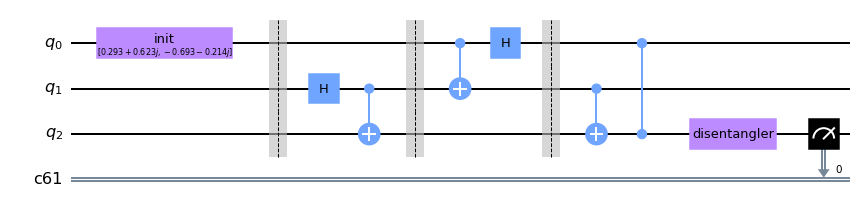

In [296]:
# test with the same example shown in the qiskit textbook
dim = 2
psi = random_statevector(dim)
cir = teleport('1',psi)
cir.draw()



Run your circuit on a simulator for a random 2-qubit state `psi` and confirm that it works.

<IPython.core.display.Latex object>

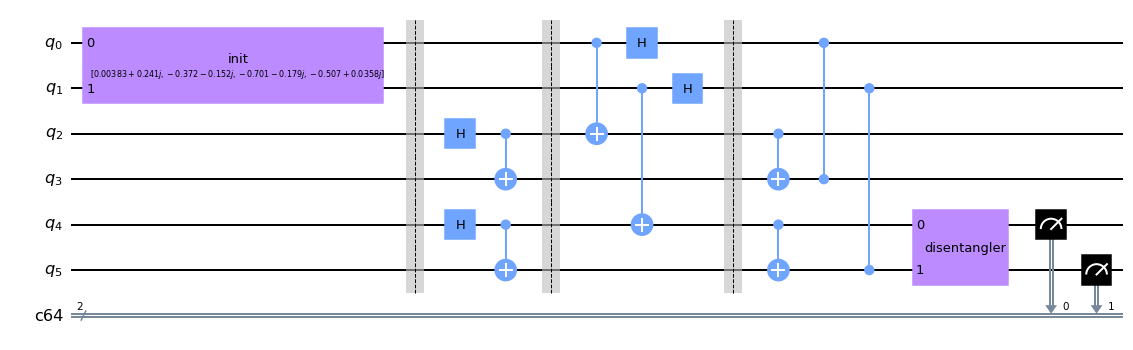

In [299]:
# test with the same example shown in the qiskit textbook
dim = 4
psi = random_statevector(dim)

# display the 2 qubit
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))

# show circuit
qc = teleport('1', psi)
qc.draw()

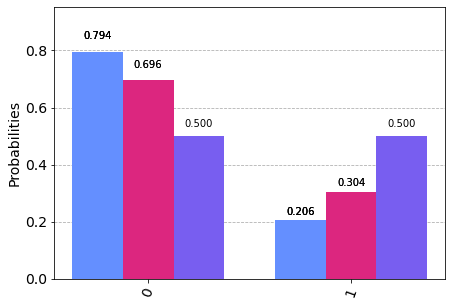

In [300]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

## Part c

Now, let's look at Section 5 of the Qiskit textbook chapter. Another option, instead of using deferred measurement, as they do, is for Bob to apply one of $I$, $X$, $Z$, or $ZX$ and then post-select for the instances in which he applied the gate appropriate for Alice's measurement. Run the quantum teleportation protocol on a real quantum computer (for a single-qubit message state), but instead of using deferred measurements, use post-selection. Create 4 quantum circuits, corresponding to the 4 operators that Bob can apply, and run them all with 1024 shots. You should run all 4 circuits in a single job by putting them in a list as you have done on previous homeworks. When running on a real device, pick the `initial_layout` so that you are only applying 2-qubit gates between connected qubits on the device you choose. Your message should be a random state as in the Qiskit chapter. What is your observed success probability?

<IPython.core.display.Latex object>

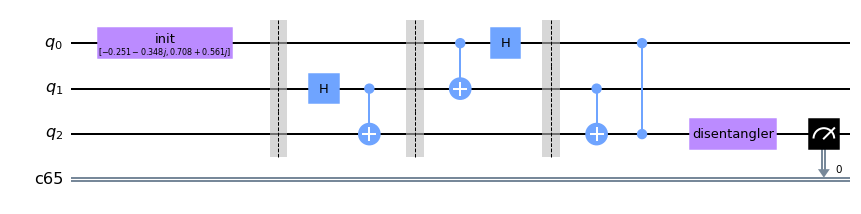

In [301]:
# test with the same example shown in the qiskit textbook
dim = 2
psi = random_statevector(dim)

# display the 2 qubit
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))

# show circuit
qc = selection_teleport('1',psi)
qc.draw()

<IPython.core.display.Latex object>

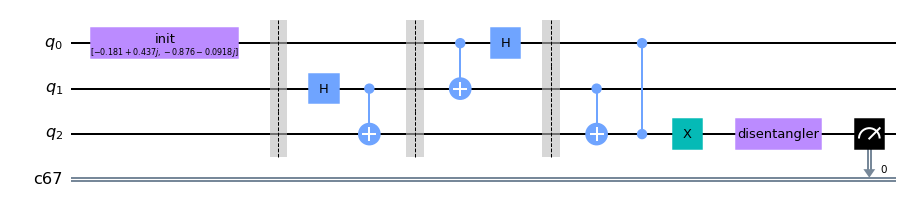

In [302]:
## pick a random 1-qubit message state
dim = 2
psi = random_statevector(dim)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))


## construct a list of the 4 quantum circuits that you will run
qc_list = []
# identity operator
qc1 = selection_teleport('1',psi)
qc_list.append(qc1)

# X gate
qc2 = selection_teleport('X',psi)
qc_list.append(qc2)

# Z gate
qc3 = selection_teleport('Z', psi)
qc_list.append(qc3)

# ZX gate
qc4 = selection_teleport('ZX',psi)
qc_list.append(qc4)

qc_list[1].draw()

In [304]:
## pick a device
# First, see what devices we are allowed to use by loading our saved accounts
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ, execute

IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-education', group='cornell-uni-2', project='physics-4481') ## or replace by following line:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
#backend = provider.get_backend('ibm-q_lima') ## you can change the backend if you'd like
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))

## pick a random 1-qubit message state
dim = 2
psi = random_statevector(dim)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))


## construct a list of the 4 quantum circuits that you will run
qc_list = []
# identity operator
qc1 = selection_teleport('1',psi)
qc_list.append(qc1)

# X gate
qc2 = selection_teleport('X',psi)
qc_list.append(qc2)

# Z gate
qc3 = selection_teleport('Z', psi)
qc_list.append(qc3)

# ZX gate
qc4 = selection_teleport('ZX',psi)
qc_list.append(qc4)


## run on the device of your choice in a single job,
## with 1024 shots, and specifying the layout so that you only use 2-qubit gates between connected qubits
max_shot = 1024
qubits = [0, 1, 2]
job = execute(qc_list,  backend, initial_layout = qubits, shots = max_shot)
job_monitor(job)  # displays job status under cell


ibmqfactory.load_account:WARNING:2021-12-03 02:23:40,792: Credentials are already in use. The existing account in the session will be replaced.


<IPython.core.display.Latex object>

Job Status: job has successfully run


[{'0': 869, '1': 155}, {'0': 495, '1': 529}, {'0': 475, '1': 549}, {'0': 284, '1': 740}]


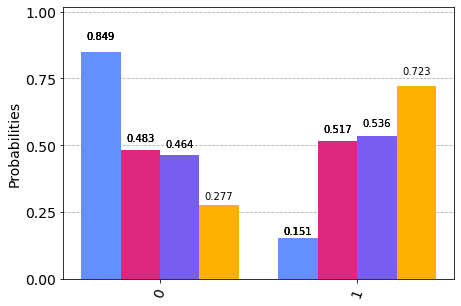

In [310]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()
print(answer)
plot_histogram(answer)

From the graph we can see that the identity circuit gives the best results with success probability 84.9%.